
================== HSV COLOR SPACE ==================


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 72.1MB/s] 


Epoch 1/30 - Train Acc: 0.9679, Val Acc: 0.9876
Epoch 2/30 - Train Acc: 0.9882, Val Acc: 0.9931
Epoch 3/30 - Train Acc: 0.9909, Val Acc: 0.9936
Epoch 4/30 - Train Acc: 0.9925, Val Acc: 0.9910
Epoch 5/30 - Train Acc: 0.9938, Val Acc: 0.9951
Epoch 6/30 - Train Acc: 0.9945, Val Acc: 0.9942
Epoch 7/30 - Train Acc: 0.9948, Val Acc: 0.9939
Epoch 8/30 - Train Acc: 0.9957, Val Acc: 0.9950
Epoch 9/30 - Train Acc: 0.9953, Val Acc: 0.9955
Epoch 10/30 - Train Acc: 0.9966, Val Acc: 0.9953
Epoch 11/30 - Train Acc: 0.9962, Val Acc: 0.9952
Epoch 12/30 - Train Acc: 0.9969, Val Acc: 0.9946
Epoch 13/30 - Train Acc: 0.9970, Val Acc: 0.9955
Epoch 14/30 - Train Acc: 0.9969, Val Acc: 0.9946
Epoch 15/30 - Train Acc: 0.9972, Val Acc: 0.9931
Epoch 16/30 - Train Acc: 0.9974, Val Acc: 0.9946
Epoch 17/30 - Train Acc: 0.9977, Val Acc: 0.9955
Epoch 18/30 - Train Acc: 0.9980, Val Acc: 0.9950
Epoch 19/30 - Train Acc: 0.9972, Val Acc: 0.9952
Epoch 20/30 - Train Acc: 0.9985, Val Acc: 0.9941
Epoch 21/30 - Train Acc: 0.99

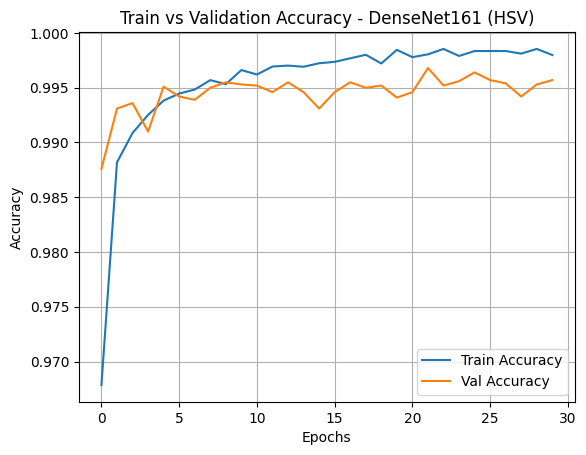


✅ Test Accuracy (HSV): 0.9965

Classification Report (HSV):
                  precision    recall  f1-score   support

     Anthracnose       1.00      0.99      1.00      1634
Bacterial Canker       1.00      1.00      1.00      1664
           Galls       1.00      0.99      0.99      1596
         Healthy       1.00      1.00      1.00      1793
          Mildew       1.00      1.00      1.00      1671
          Scorch       0.99      0.99      0.99      1643

        accuracy                           1.00     10001
       macro avg       1.00      1.00      1.00     10001
    weighted avg       1.00      1.00      1.00     10001



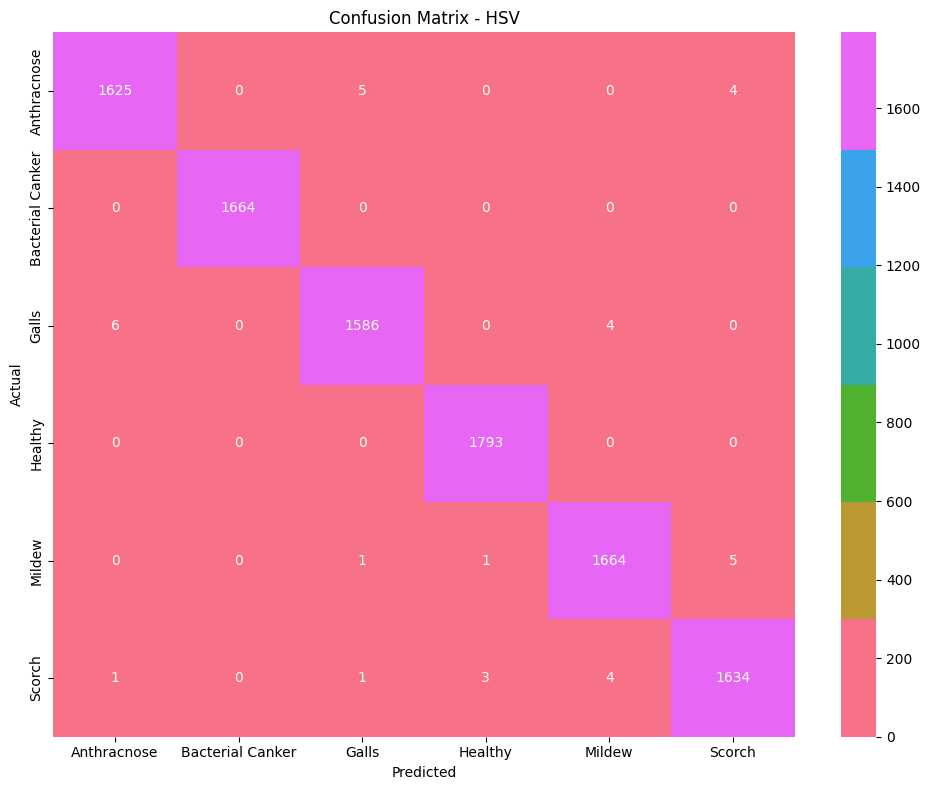


================== Lab COLOR SPACE ==================


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30 - Train Acc: 0.9745, Val Acc: 0.9780
Epoch 2/30 - Train Acc: 0.9903, Val Acc: 0.9927
Epoch 3/30 - Train Acc: 0.9916, Val Acc: 0.9929
Epoch 4/30 - Train Acc: 0.9929, Val Acc: 0.9929
Epoch 5/30 - Train Acc: 0.9939, Val Acc: 0.9937


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from matplotlib.colors import ListedColormap
from PIL import Image
import cv2
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset directories
train_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/train'
val_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/val'
test_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/test'

# Hyperparameters
NUM_CLASSES = 6
BATCH_SIZE = 16
NUM_EPOCHS = 30
LR = 1e-4

# Class names
class_names = ['Anthracnose', 'Bacterial Canker', 'Galls', 'Healthy', 'Mildew', 'Scorch']
color_palette = sns.color_palette("husl", NUM_CLASSES)
cmap_custom = ListedColormap(color_palette)

# Custom transform for HSV, Lab, YCbCr conversion
class ConvertColor:
    def __init__(self, mode='HSV'):
        self.mode = mode

    def __call__(self, img):
        img = np.array(img)
        if self.mode == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif self.mode == 'Lab':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        elif self.mode == 'YCbCr':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        return Image.fromarray(img)

# Color space variants to loop through
color_spaces = {
    'HSV': ConvertColor('HSV'),
    'Lab': ConvertColor('Lab'),
    'YCbCr': ConvertColor('YCbCr')
}

# Evaluation function
def evaluate_model(model, test_loader, color_space_name):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())

    # Accuracy
    test_accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    print(f"\n✅ Test Accuracy ({color_space_name}): {test_accuracy:.4f}")

    # Classification report
    print(f"\nClassification Report ({color_space_name}):")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=class_names,
                yticklabels=class_names,
                cmap=cmap_custom)
    plt.title(f"Confusion Matrix - {color_space_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

# Train and evaluate for each color space
for color_space_name, convert_fn in color_spaces.items():
    print(f"\n================== {color_space_name} COLOR SPACE ==================")

    # Define transform
    transform_color = transforms.Compose([
        convert_fn,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    # Load datasets
    train_dataset = datasets.ImageFolder(train_dir, transform=transform_color)
    val_dataset = datasets.ImageFolder(val_dir, transform=transform_color)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform_color)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Load model
    model = models.densenet161(pretrained=True)
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, NUM_CLASSES)
    )
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Train
    history = {'train_acc': [], 'val_acc': []}
    for epoch in range(NUM_EPOCHS):
        model.train()
        corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            corrects += torch.sum(preds == labels.data)

        train_acc = corrects.double() / len(train_loader.dataset)
        history['train_acc'].append(train_acc.item())

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_acc = val_corrects.double() / len(val_loader.dataset)
        history['val_acc'].append(val_acc.item())

        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Plot accuracy
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title(f'Train vs Validation Accuracy - DenseNet161 ({color_space_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate
    evaluate_model(model, test_loader, color_space_name)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from matplotlib.colors import ListedColormap
from PIL import Image
import cv2
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset directories
train_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/train'
val_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/val'
test_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/test'

# Hyperparameters
NUM_CLASSES = 6
BATCH_SIZE = 16
NUM_EPOCHS = 30
LR = 1e-4

# Class names
class_names = ['Anthracnose', 'Bacterial Canker', 'Galls', 'Healthy', 'Mildew', 'Scorch']
color_palette = sns.color_palette("husl", NUM_CLASSES)
cmap_custom = ListedColormap(color_palette)

# Custom transform for HSV, Lab, YCbCr conversion
class ConvertColor:
    def __init__(self, mode='Lab'):
        self.mode = mode

    def __call__(self, img):
        img = np.array(img)
        if self.mode == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif self.mode == 'Lab':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        elif self.mode == 'YCbCr':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        return Image.fromarray(img)

# Color space variants to loop through
color_spaces = {
    'HSV': ConvertColor('HSV'),
    'Lab': ConvertColor('Lab'),
    'YCbCr': ConvertColor('YCbCr')
}

# Evaluation function
def evaluate_model(model, test_loader, color_space_name):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())

    # Accuracy
    test_accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    print(f"\n✅ Test Accuracy ({color_space_name}): {test_accuracy:.4f}")

    # Classification report
    print(f"\nClassification Report ({color_space_name}):")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=class_names,
                yticklabels=class_names,
                cmap=cmap_custom)
    plt.title(f"Confusion Matrix - {color_space_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

# Train and evaluate for each color space
for color_space_name, convert_fn in color_spaces.items():
    print(f"\n================== {color_space_name} COLOR SPACE ==================")

    # Define transform
    transform_color = transforms.Compose([
        convert_fn,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    # Load datasets
    train_dataset = datasets.ImageFolder(train_dir, transform=transform_color)
    val_dataset = datasets.ImageFolder(val_dir, transform=transform_color)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform_color)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Load model
    model = models.densenet161(pretrained=True)
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, NUM_CLASSES)
    )
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Train
    history = {'train_acc': [], 'val_acc': []}
    for epoch in range(NUM_EPOCHS):
        model.train()
        corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            corrects += torch.sum(preds == labels.data)

        train_acc = corrects.double() / len(train_loader.dataset)
        history['train_acc'].append(train_acc.item())

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_acc = val_corrects.double() / len(val_loader.dataset)
        history['val_acc'].append(val_acc.item())

        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Plot accuracy
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title(f'Train vs Validation Accuracy - DenseNet161 ({color_space_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate
    evaluate_model(model, test_loader, color_space_name)


In [ ]:
import os
import shutil
# =====================
# 💾 Save Model in All Formats
# =====================
os.makedirs('/kaggle/working/saved_models', exist_ok=True)

# 1. Full model (HDF5)
model.save('/kaggle/working/saved_models/RDIFFMANGO_DenseNet161.h5')

# 2. Weights only
model.save_weights('/kaggle/working/saved_models/RDIFFMANGO_DenseNet161.weights.h5')

shutil.make_archive('/kaggle/working/mango_models_RDIFFMANGO_DenseNet161', 'zip', '/kaggle/working/saved_models')
print("\n✅ All models saved and zipped at /kaggle/working/mango_models_RDIFFMANGO_DenseNet161.zip")

In [ ]:
import torch
import os
import shutil

# 📂 Directory to save model files
save_dir = '/kaggle/working/saved_models'
os.makedirs(save_dir, exist_ok=True)

# 🧠 Assuming 'model' is your trained PyTorch model (e.g., torchvision.models.densenet201)
# Example: model = torchvision.models.densenet201(pretrained=False)

# 1️⃣ Save the full model
full_model_path = os.path.join(save_dir, 'Rdiff_DenseNet161_full.pth')
torch.save(model, full_model_path)

# 2️⃣ Save only the model weights (state_dict)
weights_path = os.path.join(save_dir, 'Rdiff_DenseNet161_weights.pth')
torch.save(model.state_dict(), weights_path)

# 📦 Zip the saved_models directory
zip_output_path = '/kaggle/working/mango_models_Rdiff_DenseNet161'
shutil.make_archive(zip_output_path, 'zip', save_dir)

print(f"\n✅ Model saved successfully:")
print(f"   - Full model: {full_model_path}")
print(f"   - Weights only: {weights_path}")
print(f"   - Zipped: {zip_output_path}.zip")